In [30]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
from nnfabrik.builder import get_data
from lurz2020.datasets.mouse_loaders import static_loaders
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop
from csng.data import MixedBatchLoader

from data_utils import get_mouse_v1_data, PerSampleStoredDataset

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'


In [4]:
config = {
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [5]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Train

In [ ]:
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": False,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 64,
        "seed": config["seed"],
        "use_cache": False,
    },
})

dataloaders = get_data(config["data"]["dataset_fn"], config["data"]["dataset_config"])

In [ ]:
config["encoder"] = {
    "model_config": {
        "init_mu_range": 0.55,
        "init_sigma": 0.4,
        "input_kern": 15,
        "hidden_kern": 13,
        "gamma_input": 1.0,
        "grid_mean_predictor": {
            "type": "cortex",
            "input_dimensions": 2,
            "hidden_layers": 0,
            "hidden_features": 0,
            "final_tanh": False
        },
        "gamma_readout": 2.439,
    },
    # "load_ckpt": "../Lurz_2020_code/notebooks/models/transfer_model.pth.tar",
    "load_ckpt": None,
    "trainer_config": {
        "track_training": True,
        "detach_core": False, # detach core of encoder (not fine-tune)
        "max_iter": 300,
        "patience": 10,
        "device": config["device"],
    }
}
model = se2d_fullgaussian2d(**config["encoder"]["model_config"], dataloaders=dataloaders, seed=config["seed"])

In [ ]:
### load pretrained model (from Lurz et al. 2020)
if config["encoder"]["load_ckpt"] is not None:
    ckpt_transfer = torch.load(config["encoder"]["load_ckpt"])
    model.load_state_dict(ckpt_transfer, strict=False)
    print(f"Loaded pretrained model from {config['encoder']['load_ckpt']}")

In [ ]:
### train
score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=config["seed"],
    **config["encoder"]["trainer_config"]
)

### save the model state
torch.save({
    "encoder_state": model_state,
    "config": config,
    "history": output,
    "score": score,
}, "model_state.pt")

In [ ]:
### eval - train encoder from scratch (no pretrained weights)
train_correlation = get_correlations(model, dataloaders["train"], device=config["device"], as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device=config["device"], as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device=config["device"], as_dict=False, per_neuron=False)

print(f"Correlation (train set):      {train_correlation:.3f}")
print(f"Correlation (validation set): {validation_correlation:.3f}")
print(f"Correlation (test set):       {test_correlation:.3f}")

In [ ]:
### eval - train encoder with the core frozen
train_correlation = get_correlations(model, dataloaders["train"], device=config["device"], as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device=config["device"], as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device=config["device"], as_dict=False, per_neuron=False)

print(f"Correlation (train set):      {train_correlation:.3f}")
print(f"Correlation (validation set): {validation_correlation:.3f}")
print(f"Correlation (test set):       {test_correlation:.3f}")

In [ ]:
### eval - train encoder with the core unfrozen
train_correlation = get_correlations(model, dataloaders["train"], device=config["device"], as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device=config["device"], as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device=config["device"], as_dict=False, per_neuron=False)

print(f"Correlation (train set):      {train_correlation:.3f}")
print(f"Correlation (validation set): {validation_correlation:.3f}")
print(f"Correlation (test set):       {test_correlation:.3f}")

## Encoder Inversion

#### Data

In [6]:
dataloaders = dict()

### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    # "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 32,
        # "batch_size": 6,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
})

### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config)

Training dataset:	 4480 samples
Validation dataset:	 512 samples
Test dataset:		 992 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([32, 1, 36, 64])
  min=-1.745  max=2.202
  mean=0.074  std=1.052
responses:
  torch.Size([32, 7334])
  min=-0.000  max=36.454
  mean=0.393  std=1.108
neuronal coordinates:
  torch.Size([7334, 3])
  min=-1.000  max=1.000
  mean=0.018  std=0.598


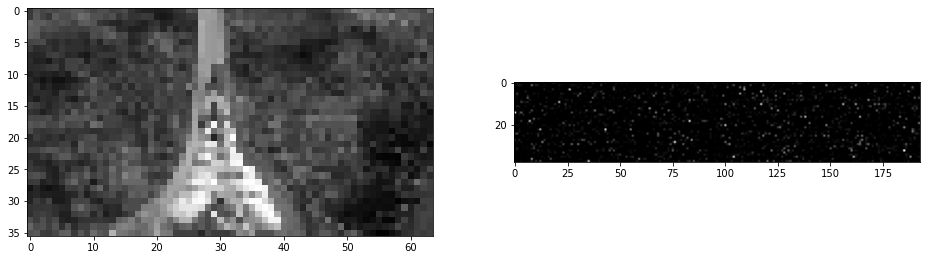

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["val"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if resp.shape[-1] % i == 0:
        reshape_to = (i, resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

#### Load Encoder

In [8]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

Loading encoder...


/home/jsobotka/miniconda3/envs/dev/lib/python3.10/site-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


#### Run Inversion

In [33]:
config["enc_inv"] = {
    "init": "zeros",
    "n_inits": 1,
    "n_steps": 10,
    "opter_cls": torch.optim.SGD,
    "opter_kwargs": {"lr": 1e-4},
    "resp_loss_fn": nn.MSELoss(),
    "stim_loss_fn": nn.MSELoss(),
    # "stim_loss_fn": SSIMLoss(
    #     window=None,
    #     # window=(0, 35, 15, 50),
    #     log_loss=True,
    #     inp_normalized=True,
    #     inp_standardized=False,
    # ),
}

In [34]:
target_stim = stim.float().to(config["device"])
target_resp = resp.float().to(config["device"])
data_key = sample_data_key
# crop_win = (slice(7, 30), slice(15, 50))

Init 0


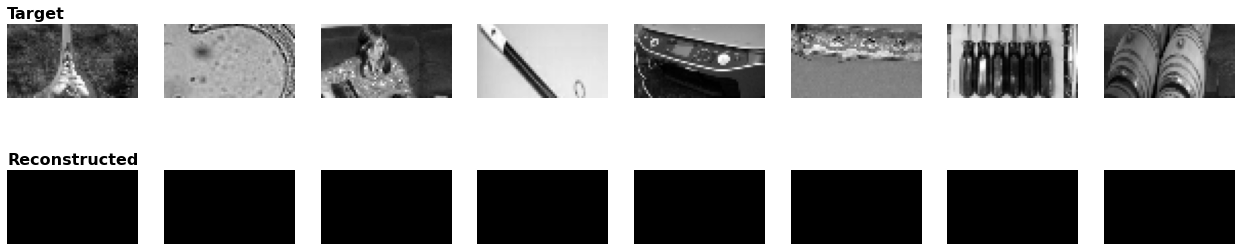

[0: 1/10]:  resp_loss=1.286  stim_loss=1.113


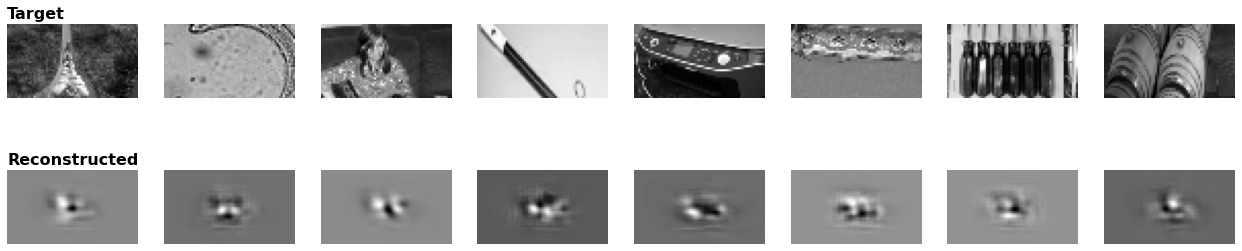

[0: 3/10]:  resp_loss=1.286  stim_loss=1.113


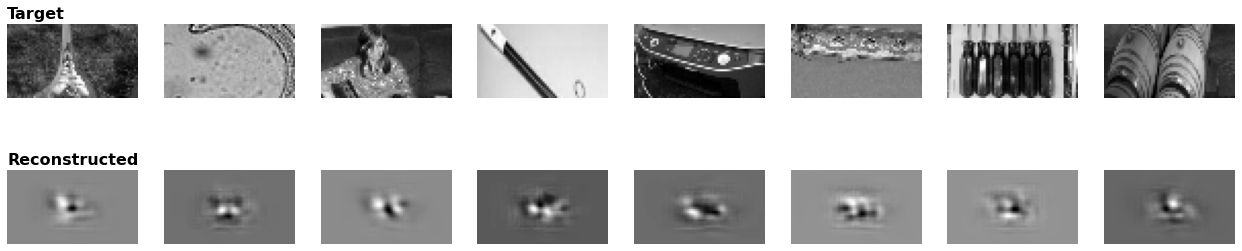

[0: 5/10]:  resp_loss=1.286  stim_loss=1.113


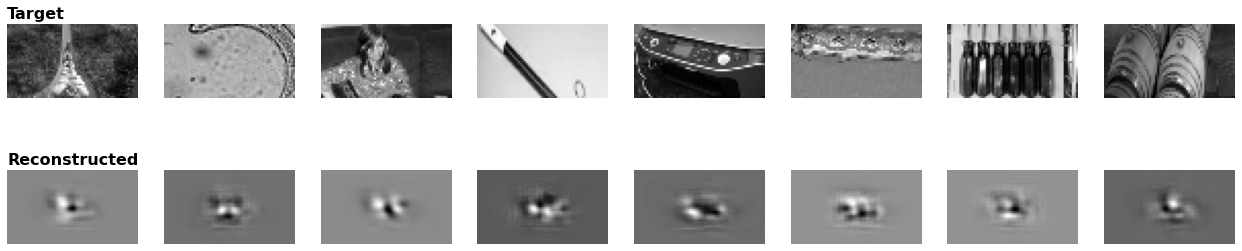

[0: 7/10]:  resp_loss=1.286  stim_loss=1.113


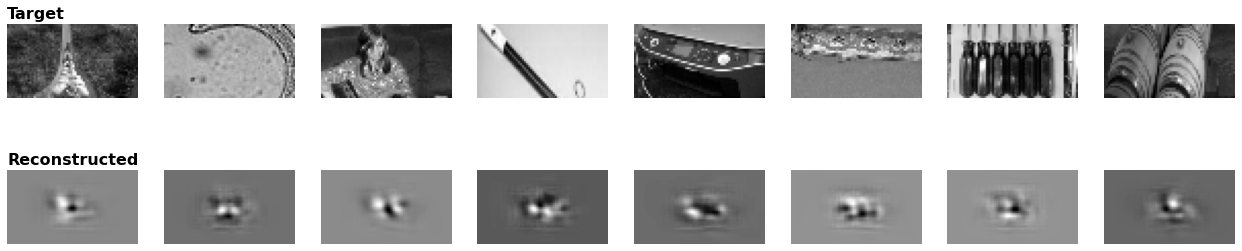

[0: 9/10]:  resp_loss=1.286  stim_loss=1.113


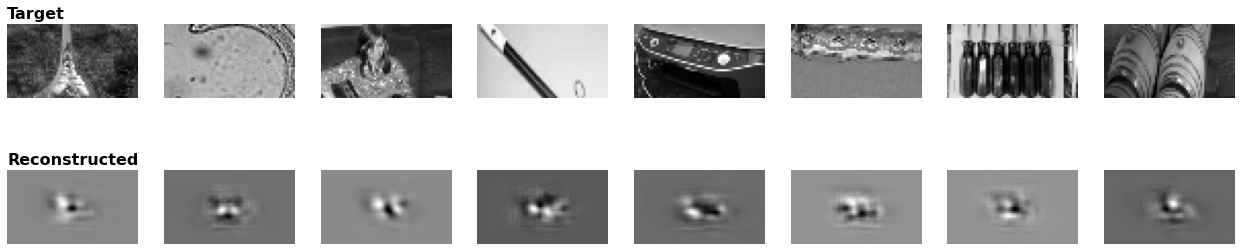

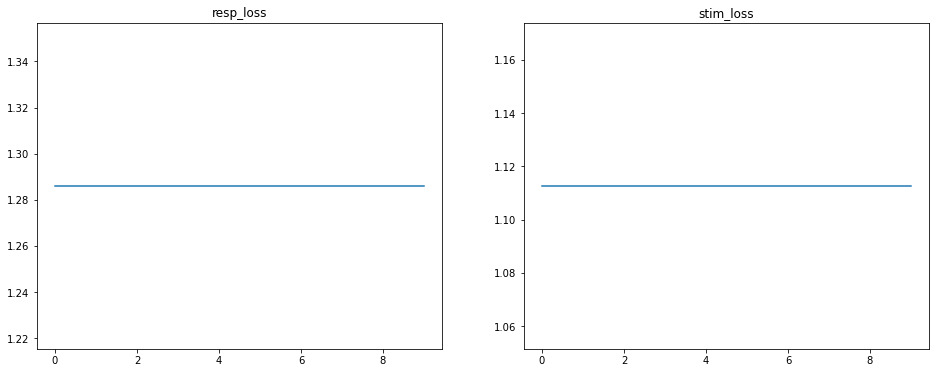

In [35]:
stim_preds = []

for init_i in range(config["enc_inv"]["n_inits"]):
    print(f"Init {init_i}")

    ### init decoded img and optimizer
    if config["enc_inv"]["init"] == "rand":
        stim_pred = torch.rand_like(target_stim, device=config["device"])
    elif config["enc_inv"]["init"] == "randn":
        stim_pred = torch.randn_like(target_stim, device=config["device"])
    elif config["enc_inv"]["init"] == "zeros":
        stim_pred = torch.zeros_like(target_stim, device=config["device"])
    else:
        raise ValueError(f"Unknown init method: {config['enc_inv']['init']}")
    stim_pred = stim_pred.requires_grad_(True)
    opter = config["enc_inv"]["opter_cls"](
        [stim_pred], **config["enc_inv"]["opter_kwargs"],
    )
    plot_comparison(target=target_stim[:8].cpu(), pred=stim_pred[:8].detach().cpu())

    ### inversion
    history = {"resp_loss": [], "stim_loss": []}
    for step_i in range(config["enc_inv"]["n_steps"]):
        opter.zero_grad()
        
        resp_pred = encoder(stim_pred, data_key=data_key).float()
        resp_loss = config["enc_inv"]["resp_loss_fn"](resp_pred, target_resp)
        resp_loss.backward()
        opter.step()

        stim_loss = config["enc_inv"]["stim_loss_fn"](stim_pred, target_stim)

        ### log
        history["resp_loss"].append(resp_loss.item())
        history["stim_loss"].append(stim_loss.item())
        if step_i % 2 == 0:
            print(f"[{init_i}: {step_i + 1}/{config['enc_inv']['n_steps']}]:  resp_loss={resp_loss.item():.3f}  stim_loss={stim_loss.item():.3f}")
            plot_comparison(target=target_stim[:8].cpu(), pred=stim_pred[:8].detach().cpu())

    ### plot loss history
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.plot(history["resp_loss"])
    ax.set_title("resp_loss")

    ax = fig.add_subplot(122)
    ax.plot(history["stim_loss"])
    ax.set_title("stim_loss")
    plt.show()
    
    stim_preds.append(stim_pred.detach().cpu())